# Method Comparisons

This section directly compares between the different methods, using simulated data. 

## Overview

A key question for interpreting prior work is to consider how the different employed methods relate to each other. To investigate this, this section simulates datasets, and applies different methods to compare their results.

In this section, the main question is the evaluate the relationship between different methods across parameters variations, to evaluate which methods are highly correlated (seeming to refelct the same thing), and which appear to provide independent estimations of the data. 

Note that due to large number of possible comparisons across different methods and different simulated parameters, in this section we necessarily restrict the comparison to a selected subset of methods, that are compared pairwise. 

In [1]:
import numpy as np
from neurodsp.sim import sim_powerlaw, sim_combined
from neurodsp.utils import create_times, set_random_seed

In [2]:
# Import the `run_comparisons` function from the custom code folder
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_comparisons
from apm.analysis import compute_all_corrs
from apm.plts import plot_dots
from apm.plts.data import plot_timeseries_and_psd
from apm.plts.settings import COLORS
from apm.sim.sim import sig_yielder_update
from apm.sim.params import sampler
from apm.sim.settings import N_SECONDS, FS, SIM_PARAMS_AP, SIM_PARAMS_COMB

/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/plts/data.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


## Simulations

In this section, we will use simulated data to compare methods. 

#### Combined signals

Calculate measures on simulated signals, across variations of aperiodic parameters in combined signals.

In [3]:
# Create a times vector for time series
times = create_times(N_SECONDS, FS)

### Settings

In [4]:
# Set random seed
set_random_seed(111)

In [5]:
# Define general settings for creating simulations
N_SIMS = 2
RETURN_SIM_PARAMS = True

In [6]:
# Define ranges to sample parameters from
samplers_ap = {'update_exp' : sampler(np.arange(-2.5, 0, 0.1))}
samplers_comb = {'update_comb_exp' : sampler(np.arange(-2.5, 0.1, 0.1)),
                 'update_pow' : sampler(np.arange(0, 1.1, 0.1), probs = [0.30] + ([0.07] * 10)),
                 'update_freq' : sampler(np.arange(5, 36, 1))}

#### Example signals - aperiodic

In [7]:
# Initialize signal generator for aperiodic signals
sig_gen_ap = sig_yielder_update(sim_powerlaw, SIM_PARAMS_AP, samplers_ap, N_SIMS, RETURN_SIM_PARAMS)

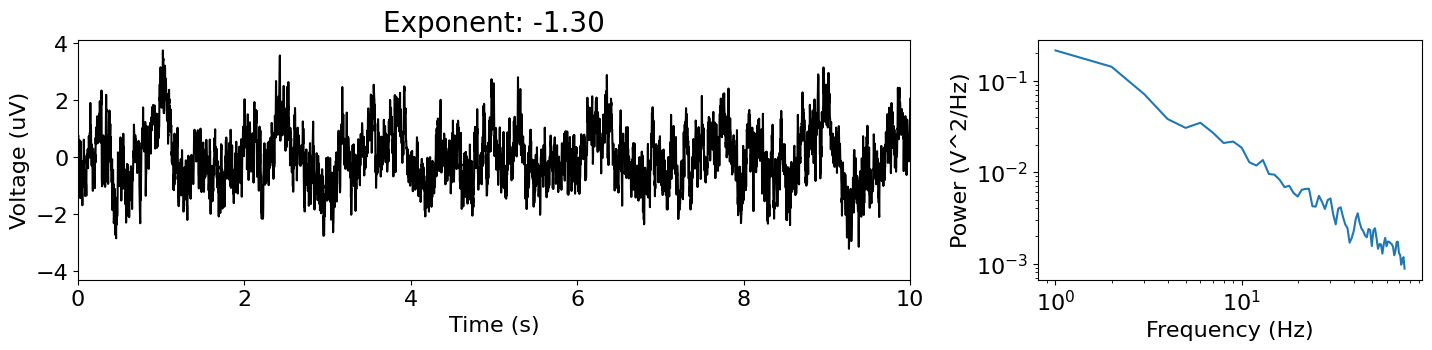

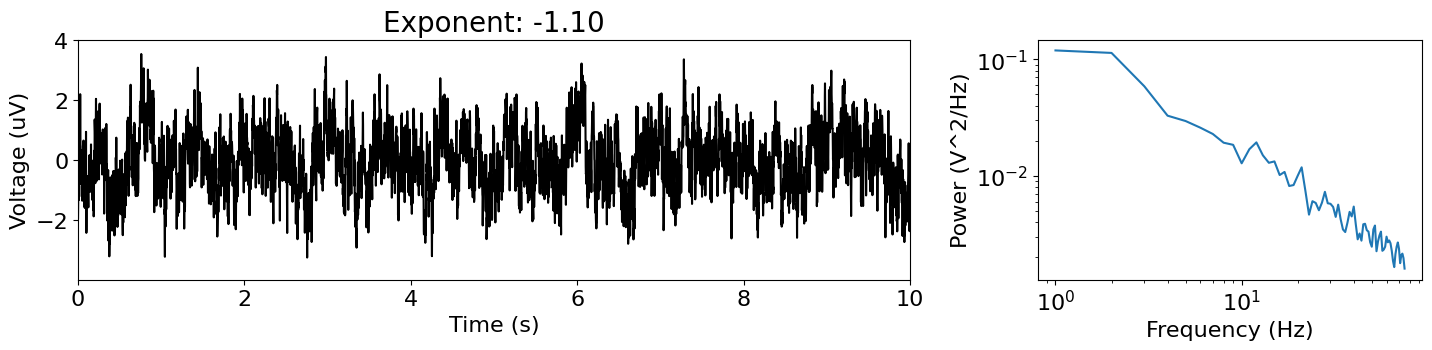

In [8]:
# Plot example generated signals
for cur_sig_ap, cur_params_ap in sig_gen_ap:
    plot_timeseries_and_psd(times, cur_sig_ap, FS, xlim=[0, 10],
                            title=str('Exponent: {:1.2f}'.format(cur_params_ap['exponent'])))

#### Example signals - combined

In [9]:
# Initialize signal generator for combined signals
sig_gen_comb = sig_yielder_update(sim_combined, SIM_PARAMS_COMB, samplers_comb, N_SIMS, RETURN_SIM_PARAMS)

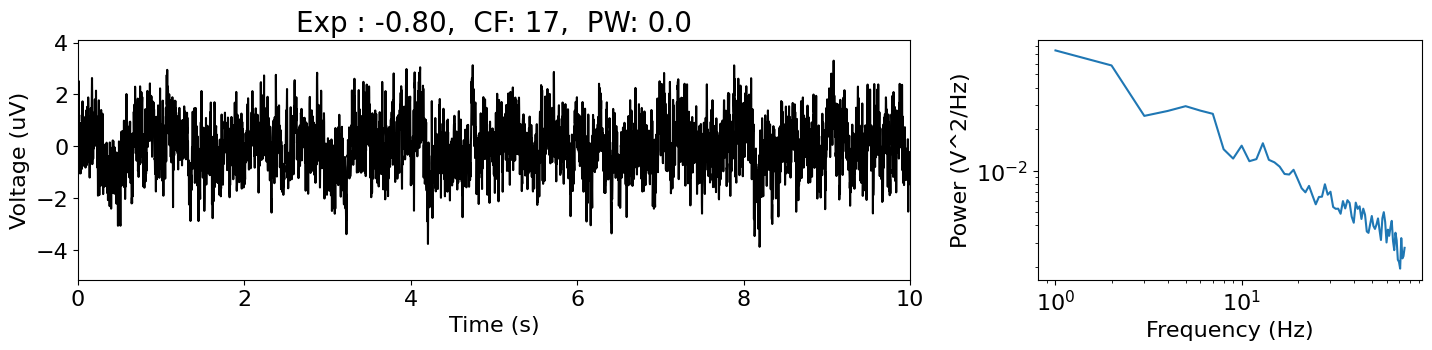

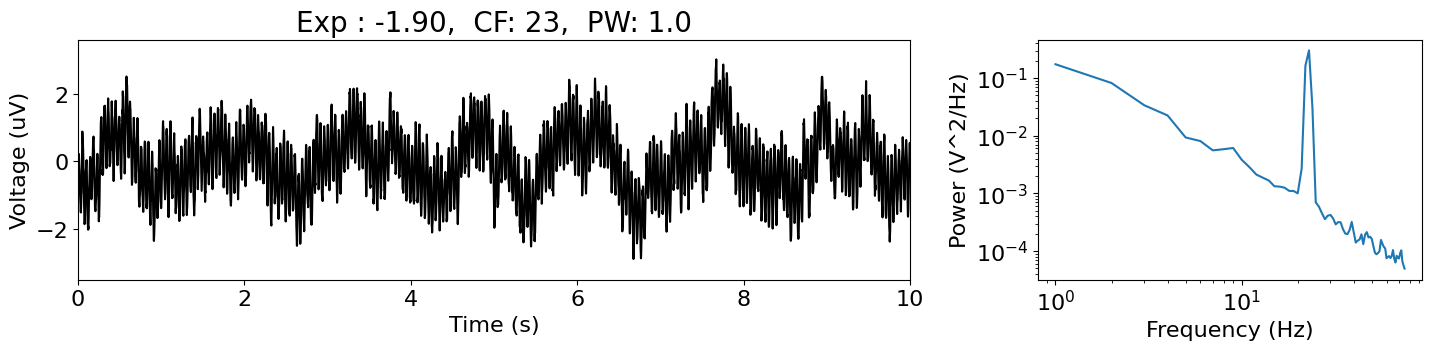

In [10]:
# Plot example generated signals
for cur_sig_comb, cur_params_comb in sig_gen_comb:
    plot_timeseries_and_psd(times, cur_sig_comb, FS, xlim=[0, 10],
                            title='Exp : {:1.2f},  CF: {:2.0f},  PW: {:1.1f}'.format(\
                                cur_params_comb['components']['sim_powerlaw']['exponent'], 
                                cur_params_comb['components']['sim_oscillation']['freq'], 
                                cur_params_comb['component_variances'][1]))

## Code Approach: `run_comparisons`

Here, we will briefly introduce the general strategy and code used to run the simulations. 

The overarching function used to run simulation comparisons is the `run_comparisons` function.

This approach allows for:
- defining a procedure to simulate time series
- defining a set of measures to apply to the simulated time series
- applying the set of measures across simulated instances, sampling from parameter ranges

In [11]:
# Check the documentation for `run_comparisons`
print(run_comparisons.__doc__)

Compute multiple measures of interest across the same set of simulations.

    Parameters
    ----------
    sim_func : callable
        A function to create simulated time series.
    sim_params : dict
        Input arguments for `sim_func`.
    measures : dict
        Functions to apply to the simulated data.
        The keys should be functions to apply to the data.
        The values should be a dictionary of parameters to use for the method.
    samplers : dict
        Information for how to sample across parameters for the simulations.
        The keys should be string labels of which parameter to update.
        The values should be data ranges to sample for that parameter.
    n_sims : int
        The number of simulations to run.
    return_sim_params : bool, default: False
        Whether to collect and return the parameters of all the generated simulations.
    verbose : bool, optional, default: False
        Whether to print out simulation parameters.
        Used for check

Next, we can run an example of using `run_comparisons`.

To do so, we will define an example analysis to apply some measures of interest (here, computing the mean and the variance) across samples of simulations of powerlaw data.

In [12]:
# Define the measures to apply to the simulated signals
measures = {np.var : {}, np.mean : {}}

#### Run simulations across variations in exponent

In [13]:
# Run comparisons across samples of aperiodic noise
results1, all_sim_params1 = run_comparisons(\
    sim_powerlaw, SIM_PARAMS_AP, measures, samplers_ap, n_sims=3, return_sim_params=True, verbose=True) 

{'n_seconds': 30, 'fs': 500, 'f_range': (0.5, None), 'exponent': -0.29999999999999805}
{'n_seconds': 30, 'fs': 500, 'f_range': (0.5, None), 'exponent': -0.6999999999999984}
{'n_seconds': 30, 'fs': 500, 'f_range': (0.5, None), 'exponent': -1.0999999999999988}


In [14]:
# Check output simulation parameters
all_sim_params1

,n_seconds,fs,f_range,exponent
0,30,500,"(0.5, None)",-0.3
1,30,500,"(0.5, None)",-0.7
2,30,500,"(0.5, None)",-1.1


In [15]:
# Check output values of computed measures
results1

{'var': array([1., 1., 1.]),
 'mean': array([1.30266168e-18, 1.32634644e-17, 7.10542736e-18])}

In [16]:
# Compute the correlations between output measures
compute_all_corrs(results1)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/tom/opt/anaconda3/envs/apm/li

{'var': {'mean': (0.5, 0.6666666666666667, (nan, nan))},
 'mean': {'var': (0.5, 0.6666666666666667, (nan, nan))}}

#### Run simulations across variations in multiple parameters

In [17]:
# Run comparisons across samples of aperiodic noise
results2, all_sim_params2 = run_comparisons(\
    sim_combined, SIM_PARAMS_COMB, measures, samplers_comb, n_sims=25, return_sim_params=True, verbose=False) 

In [18]:
# Check output simulation parameters
all_sim_params2.head(5)

,n_seconds,fs,exponent,f_range,freq,var_ap,var_pe,has_osc
0,30,500,-2.4,"(0.5, None)",25,1,0.6,True
1,30,500,-0.5,"(0.5, None)",27,1,0.0,False
2,30,500,-1.5,"(0.5, None)",22,1,0.0,False
3,30,500,-0.6,"(0.5, None)",21,1,0.0,False
4,30,500,-1.1,"(0.5, None)",32,1,0.8,True


In [19]:
# Check output values of computed measures
results2

{'var': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 'mean': array([ 7.57912251e-18, -1.80004160e-17,  7.57912251e-18, -2.48689958e-18,
        -6.15803704e-18, -1.04805054e-17, -1.65793305e-17, -1.71714494e-17,
         1.52766688e-17,  8.52651283e-18, -4.73695157e-18, -4.73695157e-19,
         9.05941988e-18, -9.47390314e-19, -1.46845499e-17,  5.68434189e-18,
         1.13686838e-17, -1.91846539e-17, -5.68434189e-18,  3.31586610e-18,
        -1.89478063e-18,  1.42108547e-18, -5.68434189e-18,  9.47390314e-19,
        -2.17899772e-17])}

In [20]:
# Compute the correlations between output measures
compute_all_corrs(results2)

{'var': {'mean': (-0.15856866712426806,
   0.4490127359636049,
   (-0.5139221637993532, 0.23895942482968174))},
 'mean': {'var': (-0.15856866712426806,
   0.4490127359636049,
   (-0.5139221637993532, 0.23895942482968174))}}

### Evaluating Results

After computing the measures, we can examine the results, comparing between different measurements.

In [21]:
# Collect colors for each value based on presence of an oscillation
colors = [COLORS['CM'] if osc else COLORS['AP'] for osc in all_sim_params2.has_osc]

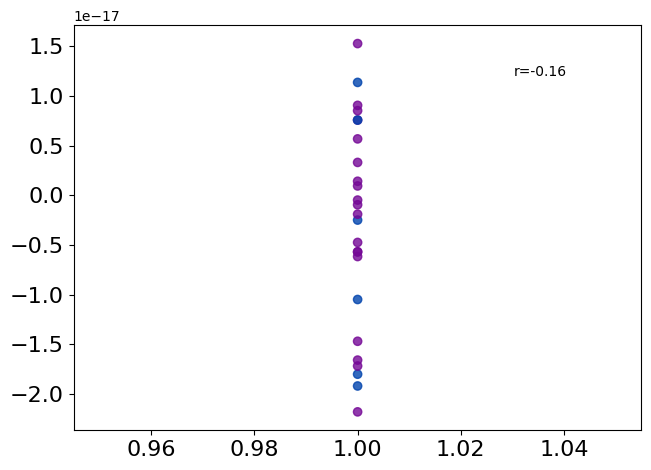

In [22]:
# Plot the computed measures against each other
plot_dots(results2['var'], results2['mean'], c=colors, alpha=0.8)